In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit
import h5py
from IPython.display import Image
from sklearn.decomposition import PCA, TruncatedSVD, SparseCoder, NMF
from sklearn.decomposition import MiniBatchDictionaryLearning, KernelPCA
import random
import pandas as pd
from matplotlib.ticker import StrMethodFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

/home/fernando/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
def gauss2 (x,a,mu,sigma,a2,mu2,sigma2):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2)) + a2*np.exp(-(x - mu2)**2 / (2 * sigma2**2))

def gaussiana(x,a,mu,sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

def snr(x):
    return (np.mean(x))/(np.std(x))

def red(noise,lenght=144000):
    output = np.ones(lenght)
    for i in range(lenght - 1):
        output[i]=(0.5 * (noise[i] + noise[i+1]))
    return output

def genruidorojo(noise,lenght=144000): 
    x=genruido(noise,lenght)
    x2=red(x,lenght)
    x=(x+x2)
    return set_noise_level(x,noise)
    
    
def set_noise_level(curve,noise):
    curve=curve/np.mean(curve)
    signal_noise=snr(curve)
    curve=curve-1
    curve=curve*(1/(noise/signal_noise))
    return curve+1
    
def genruido(noise,lenght=288000): 
    a=2862.316781326982 
    mu=0.9976487554779495 
    sigma=0.1018979580252512
    a2=5417.280508101456 
    mu2=0.9932463577214291 
    sigma2=-0.040626701263867235
    x=np.linspace(0.1,2,lenght)
    y=gauss2(x,a,mu,sigma,a2,mu2,sigma2)
    C = np.cumsum(y)
    Cnorm=C/np.max(C)
    Cinv = interpolate.interp1d(Cnorm,x)
    s = np.random.uniform(0,1,lenght)
    ruido=Cinv(s)
    return set_noise_level(ruido,noise)   

def outliers(x):
    size=x.shape[0]
    std=np.std(x)
    mean=np.mean(x)
    tt = np.where(np.abs(x-mean) > std*5)[0]
    for i in tt:
        x[i]=(x[i+1]+x[i-1])/2
    return x

def prom_mov(x,mov):
	size=x.shape[0]
	x_mov=np.zeros(size-mov)
	for i in range(size-mov):
		x_mov[i]=np.sum(x[i:i+mov])/mov
	return x_mov

def med_mov(x,mov):
	size=x.shape[0]
	x_mov=np.zeros(size-mov)
	for i in range(size-mov):
		x_mov[i]=np.median(x[i:i+mov])
	return x_mov


def tiempo(x,freq=20):
	size=x.shape[0]
	t=size/(freq*60)
	return np.linspace(0,t,size)

def dexp(x,base,a,b,a2,b2):
    expo=np.zeros(len(x))
    for i in range(len(x)):
        if x[i]>= 0:
            expo[i]=base+a*np.exp(-x[i]/b)+a2*np.exp(-x[i]/b2)
        else:
            expo[i]=base+a*np.exp(x[i]/b)+a2*np.exp(x[i]/b2)
    return expo
            
    
def ruido_real(noise,base,a,b,a2,b2,lenght=288000):
    ruido=genruido(noise,lenght)
    freq_ruido = np.fft.fftfreq(lenght,d=0.05)
    fft_ruido=np.fft.fft(ruido)
    expo=dexp(freq_ruido,base,a,b,a2,b2)
    ruido=np.fft.ifft(fft_ruido.real*expo)
    return set_noise_level(ruido.real,noise) 

def fourierfilter(x,cutfreq):
	size=x.shape[0]
	freq = np.fft.fftfreq(size,d=0.05)
	x_fft=np.fft.fft(x)
	mask = np.abs(freq) > cutfreq
	x_fft[mask]=0.1    
	x_fft=np.fft.ifft(x_fft)
	return x_fft

In [6]:
curva_luz=np.loadtxt(fname='../data/kepler17b_291_356_10.txt')

In [7]:
curva_luz_2=np.loadtxt(fname='../data/kepler17b_392_369_10.txt')

In [ ]:
plt.plot(curva_luz)
plt.plot(curva_luz_2)
#plt.plot(curva_luz/curva_luz_2)

In [8]:
t = tiempo(curva_luz)

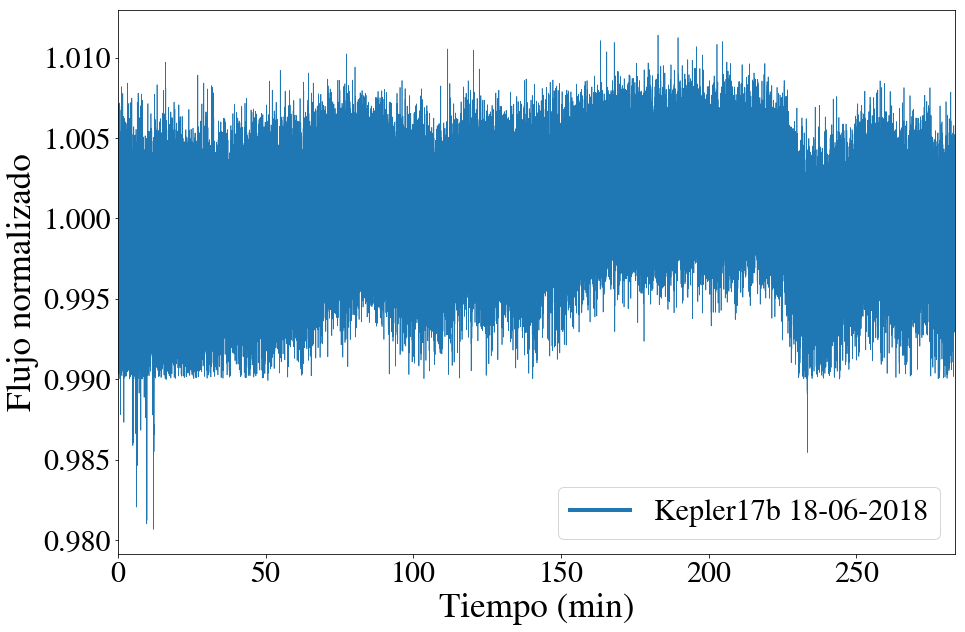

In [10]:
plt.figure(figsize=(15,10))
plt.plot(t,curva_luz,linewidth=0.7,label='Kepler17b 18-06-2018')
plt.xlabel('Tiempo (min)',size=35)
plt.ylabel('Flujo normalizado',size=35)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlim(0,t.max())
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

#plt.savefig('../reports/figures/fotometria_apertura.png',dpi=200)

In [11]:
curva_diff=np.array(curva_luz/curva_luz_2)

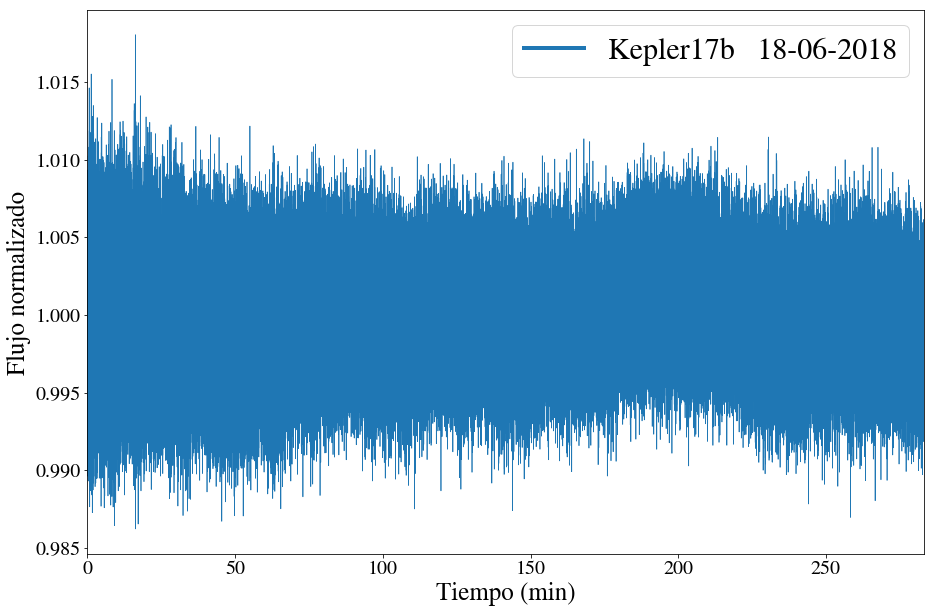

In [12]:
plt.figure(figsize=(15,10))
plt.plot(t,curva_diff,linewidth=0.7,label='Kepler17b   18-06-2018')
plt.xlabel('Tiempo (min)',size=25)
plt.ylabel('Flujo normalizado',size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(0,t.max())
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 
#plt.savefig('../reports/figures/fotometria_diferencial.png',dpi=100)

Esta curva tiene 296600 puntos.


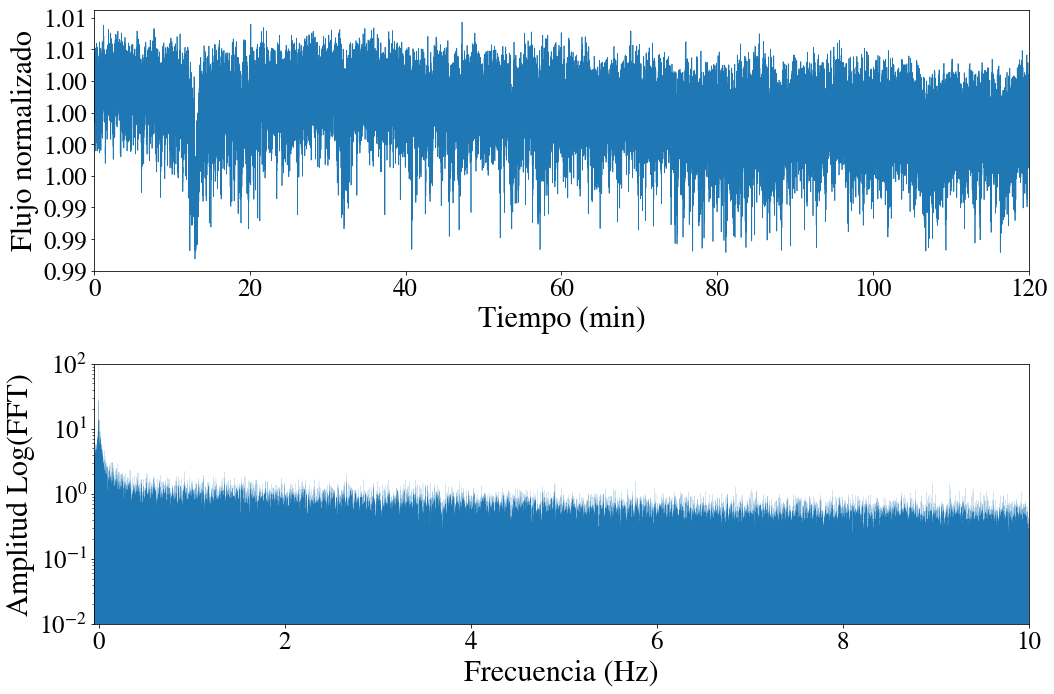

In [13]:
lc=np.loadtxt('../data/hat14_30may.out')
print('Esta curva tiene',np.shape(lc)[0],'puntos.')
x1=98000
x2=x1+144000 
lc=lc[x1:x2] #INTERVALO DE 144000 PUNTOS PARA ESTUDIAR
lc=outliers(lc) #REMOVEMOS OUTLIERS
############CALCULAMOS TIEMPO, SNR Y LONGITUD DE LA CURVA RESPECTIVAMENTE
t_lc=tiempo(lc)
snr_lc=snr(lc)
size=np.shape(lc)[0]
############TRANSFORMADA DE FOURIER DE LA CURVA DE LUZ
freq_lc = np.fft.fftfreq(size,d=0.05)
fft_lc=np.fft.fft(lc)
###PLOTEAR CURVAS
fig = plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(t_lc,lc,linewidth=0.75)
#plt.title('HAT14 30may SNR={0:.4f}'.format(snr_lc))
plt.xlabel('Tiempo (min)',size=30)
plt.ylabel('Flujo normalizado',size=30)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlim(0,t_lc.max())
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.subplot(2, 1, 2)
plt.semilogy(freq_lc,fft_lc.real,linewidth=0.1); # GRAFICANDO LA FFT DE LA CURVA DE LUZ
plt.xlabel('Frecuencia (Hz)',size=30)
plt.ylabel('Amplitud Log(FFT)',size=30)
plt.xlim(-0.05,10)
plt.ylim(0.01,100)
plt.xticks(size=25)
plt.yticks(size=25)

fig.tight_layout(pad=2)

#plt.savefig('../reports/figures/transformada_fourier.png',dpi=100)

In [9]:
lcx=np.loadtxt('../data/wasp74bst.out'); #### WASP74B SIN TRANSITO DEL 28 DE MAYO 2017 FRAMETRANSFER
#lcx=np.loadtxt('wasp48b_152_139_10.txt');
size=lcx.shape[0]
#########################REMOVIENDO OUTLIERS
std1=np.std(lcx)
mean1=np.mean(lcx)

In [10]:
for i in range(size):
	if np.absolute(lcx[i]-mean1) > (std1*5):
		lcx[i]=mean1

In [11]:
lcx_norm=lcx/np.mean(lcx)

In [12]:
for i in range(size):
	lcx[i]=lcx[i]/mean1

In [13]:
curva_luz=lcx[:144000]
t=tiempo(curva_luz)

In [14]:
histo2,x1=np.histogram(curva_luz,100)
x2=(x1[:-1]+x1[1:])/2

In [15]:
def gauss2 (x,a,mu,sigma,a2,mu2,sigma2):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2)) + a2*np.exp(-(x - mu2)**2 / (2 * sigma2**2))

In [16]:
popt,pcov = curve_fit(gauss2, x2, histo2,maxfev=3000)

In [17]:
print('coeficientes del gaussgaussfit son a:{0} mu:{1} sigma:{2} a2:{3} mu2:{4} sigma2:{5}'.format(*popt))

coeficientes del gaussgaussfit son a:2862.316781326982 mu:0.9976487554779495 sigma:0.1018979580252512 a2:5417.280508101456 mu2:0.9932463577214291 sigma2:-0.040626701263867235


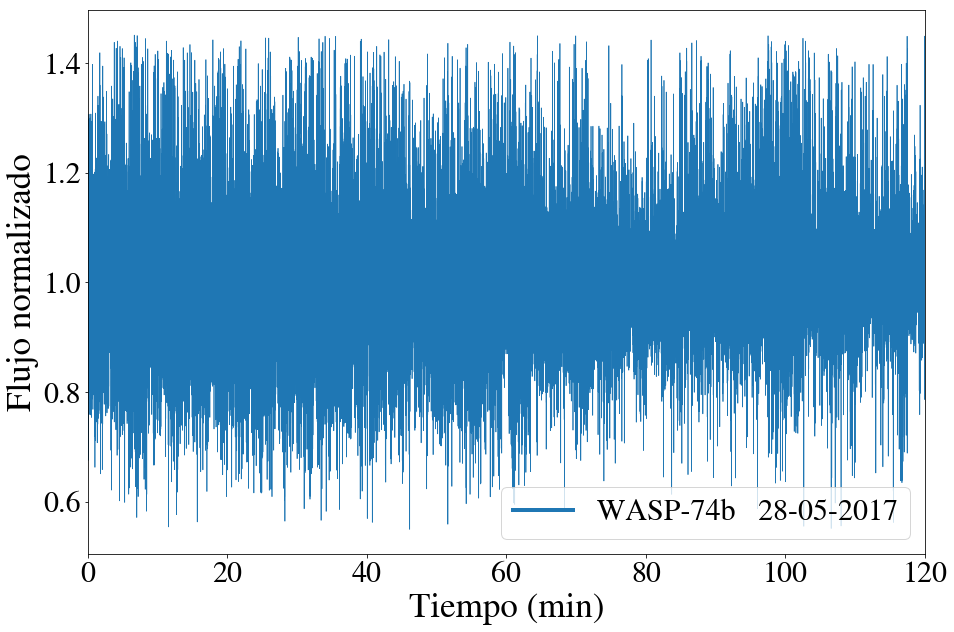

In [23]:
plt.figure(figsize=(15,10))
plt.plot(t,curva_luz,linewidth=0.7,label='WASP-74b   28-05-2017')
plt.xlabel('Tiempo (min)',size=35)
plt.ylabel('Flujo normalizado',size=35)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlim(0,t.max())
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 
#plt.savefig('../reports/figures/curva_luz_wasp.png',dpi=200)

PROM MOV

In [24]:
lc_mov=prom_mov(curva_luz,1200)
t_mov=tiempo(lc_mov)
lc_med=med_mov(curva_luz,1200)

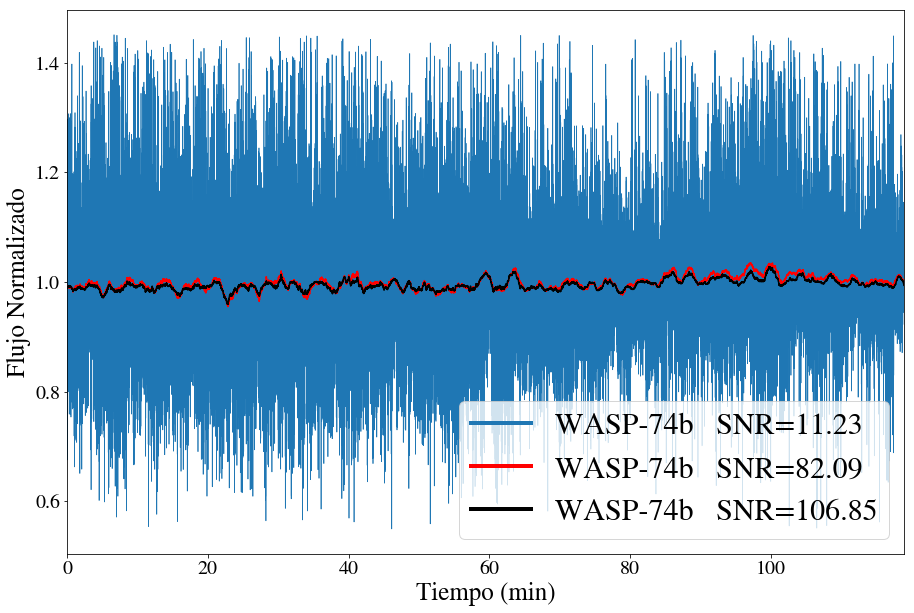

In [25]:
plt.figure(figsize=(15,10))
plt.plot(t,curva_luz,linewidth=0.7,label='WASP-74b   SNR={0:.2f}'.format(snr(curva_luz)))
plt.plot(t_mov,lc_mov,linewidth=1.5,color = 'r',label='WASP-74b   SNR={0:.2f}'.format(snr(lc_mov)))
plt.plot(t_mov,lc_med,linewidth=1.5, color = 'k',label='WASP-74b   SNR={0:.2f}'.format(snr(lc_med)))
plt.xlabel('Tiempo (min)',size=25)
plt.ylabel('Flujo Normalizado',size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(0,t_mov.max())
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 
plt.savefig('../reports/figures/wasp_prom_mov.png',dpi=200)

Fourier fil

In [18]:
lc_fil=fourierfilter(curva_luz,0.002)

/home/fernando/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


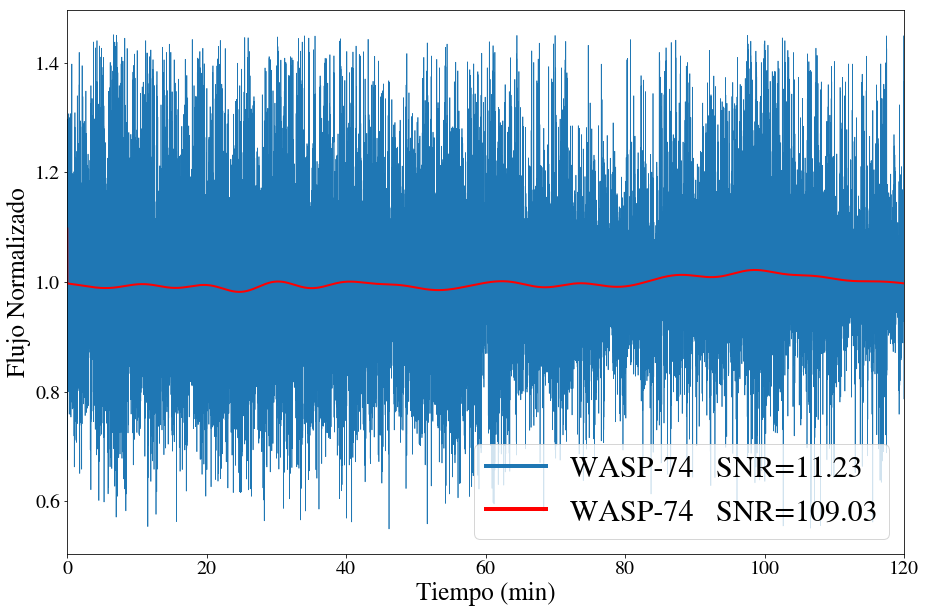

In [27]:
plt.figure(figsize=(15,10))
plt.plot(t,curva_luz,linewidth=0.7,label='WASP-74   SNR={0:.2f}'.format(snr(curva_luz)))
plt.plot(t,lc_fil,linewidth=2,color='red',label='WASP-74   SNR={0:.2f}'.format(snr(lc_fil.real)))
plt.xlabel('Tiempo (min)',size=25)
plt.ylabel('Flujo Normalizado',size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(0,t.max())
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 
#plt.savefig('../reports/figures/wasp_four_fil.png',dpi=200)

In [28]:
x= np.zeros(1000)*0.1
freq=np.linspace(-10,10,1000)

In [29]:
x[300:700]=1
x[:300]=0.1
x[700:]=0.1

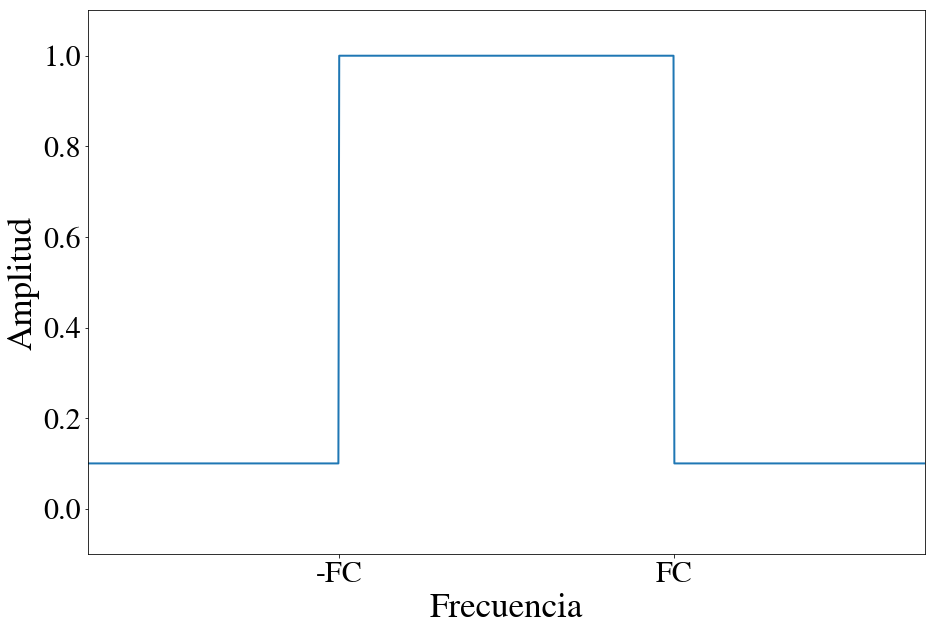

In [30]:

plt.figure(figsize=(15,10))
plt.plot(freq,x,linewidth=2,label='Filtro pasa-bajas')
plt.xlabel('Frecuencia',size=35)
plt.ylabel('Amplitud',size=35)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlim(-10,10)
plt.ylim(-0.1,1.1)
plt.xticks([freq[300],freq[700]],['-FC','FC'])
for line in leg.get_lines():
    line.set_linewidth(4.0) 
#plt.savefig('../reports/figures/filtro_pasabajas.png',dpi=200)

In [4]:
def gauss(x,a,mu,sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

NameError: name 'histo2' is not defined

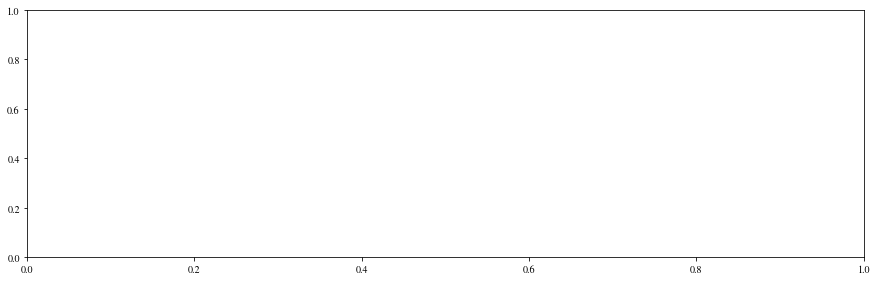

In [5]:
fig=plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(x2,histo2,'ro',markersize=5,label='Histograma del flujo \nde WASP-74b')           ##histograma
plt.plot(x2,gauss2(x2,*popt),linewidth=2,label='Modelo Gaussiano')   ###ajuste
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel("Frecuencia",size=25)
leg= plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

plt.subplot(2, 1, 2)
plt.plot(x2,histo2-gauss2(x2,*popt),'ro',markersize=5)
plt.ylabel("Residuales",size=25)
plt.xlabel("Valor de flujo normalizado",size=25)
plt.xticks(size=20)
plt.yticks(size=20)
leg= plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

fig.tight_layout(pad=3.0)
#plt.savefig('../reports/figures/ajuste_modelo_gaussiano.png',dpi=300)

In [6]:
gauss_1=gauss(x2,popt[0],popt[1],popt[2])
gauss_2=gauss(x2,popt[3],popt[4],popt[5])
gauss_3=gauss_1+gauss_2
fig=plt.figure(figsize=(15,10))
plt.plot(x2,gauss_1/gauss_3.max(),label= '$G_{1}(t)$',linewidth=3)    ###ajuste Lorentz
plt.plot(x2,gauss_2/gauss_3.max(),label= '$G_{2}(t)$',linewidth=3)    ###ajuste Lorentz
plt.plot(x2,gauss_3/gauss_3.max(),label= '$m(t)$',linewidth=3)    ###ajust
plt.ylabel("Amplitud normalizada",size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel("Valor de flujo normalizado",size=25)
plt.xticks(size=20)
plt.yticks(size=20)
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

#plt.savefig('../reports/figures/componentes_gaussianas.png',dpi=300)

NameError: name 'popt' is not defined

In [27]:
len(gauss_1)

100

La curva de luz completa tiene: 169700 frames


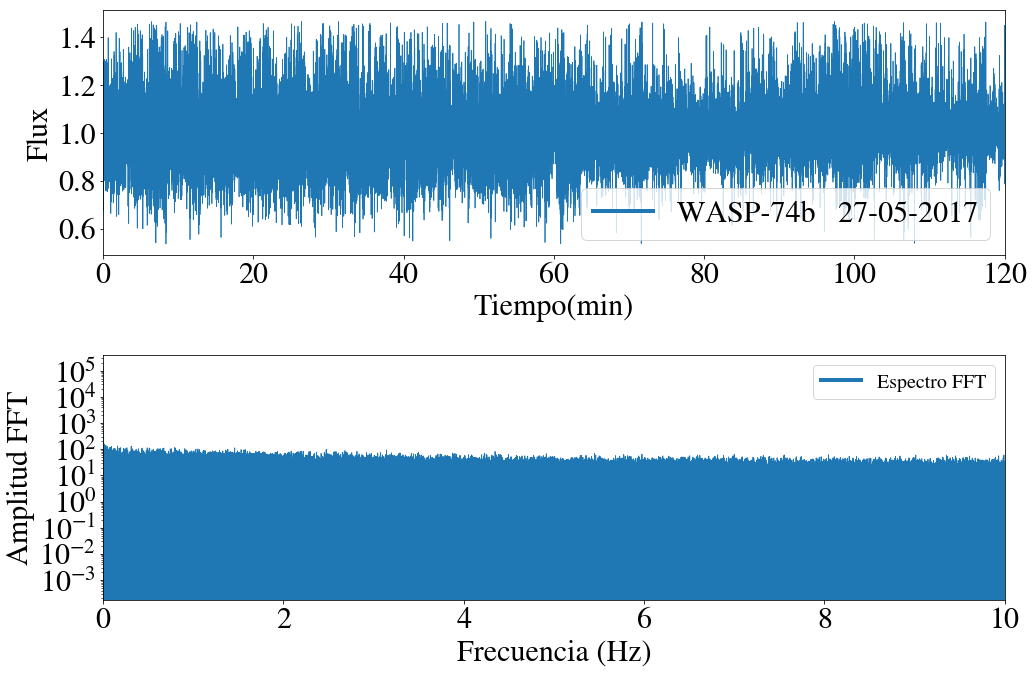

In [19]:
lc8=np.loadtxt('../data/wasp74bst.out')
print('La curva de luz completa tiene:',np.shape(lc8)[0],'frames')
x1=0
x2=x1+144000
lc=(lc8[x1:x2])
size=len(lc)
mean1=np.mean(lc)
std1=np.std(lc)
for i in range(size):
	if np.absolute(lc[i]-mean1) > (std1*5):
		lc[i]=mean1


#lc=outliers(lc)
###############SIN DETRENDING
size=np.shape(lc)[0]      
#############CON DETRENDING
#lc_mov=prom_mov(lc,mov)
#size=np.shape(lc_mov)[0]
#lc=(lc[:size]-lc_mov)+1

############CALCULAMOS TIEMPO Y SNR
t_lc=tiempo(lc)
snr_lc=snr(lc)
#############TRANSFORMADA DE FOURIER DEL RUIDO "REAL"
#ruido_r=ruido_real(snr_lc,1,4.09589900e+00, 15.55364026e-02, 20,8.90201637e-03,size)
#fft_ruido_real=np.fft.fft(ruido_r)
############TRANSFORMADA DE FOURIER DE LA CURVA DE LUZ
freq = np.fft.fftfreq(size,d=0.05)
fft_lc=np.fft.fft(lc)


#expo=dexp(freq,1,4.09589900e+00, 15.55364026e-02, 20,8.90201637e-03)
fig=plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(t_lc,lc,linewidth=0.75,label='WASP-74b   27-05-2017')
#plt.title('Name:Wasp74b Date:06ago16 SNR={0:.4f} Cam:Ixon Tel:84cm'.format(snr_lc))
plt.xlabel('Tiempo(min)',size=30)
plt.ylabel('Flux',size=30)
plt.xlim(0,120)
#plt.ylim(0.975,1.02)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

plt.subplot(2, 1, 2)
plt.semilogy(freq,fft_lc.real,linewidth=0.85,label='Espectro FFT'); # GRAFICANDO LA FFT DE LA CURVA DE LUZ
#plt.semilogy(freq,expo,linewidth=2,color='r',label='Envolvente exponencial')
plt.xlabel('Frecuencia (Hz)',size=30)
plt.ylabel('Amplitud FFT',size=30)
plt.xlim(0,10)
#plt.ylim(0.1,1000)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

fig.tight_layout(pad=3.0)
#plt.savefig('../reports/figures/curva_ajuste_espedfdfctro.png',dpi=300)

La curva de luz completa tiene: 244741 frames


NameError: name 'fft_transito_wasp' is not defined

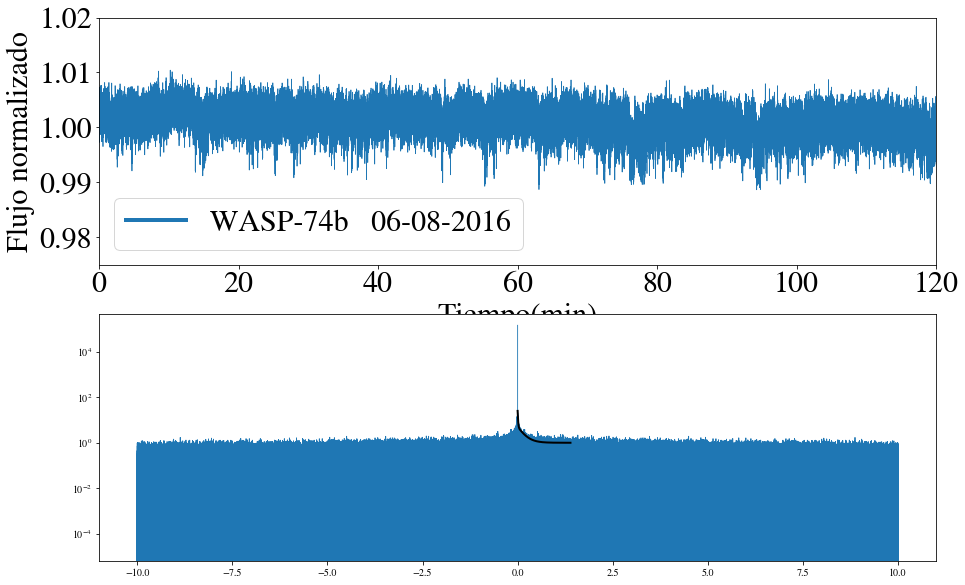

In [20]:
lc8=np.loadtxt('../data/wasp74b_06ago.out')
print('La curva de luz completa tiene:',np.shape(lc8)[0],'frames')
x1=0
x2=x1+144000
lc=(lc8[x1:x2])
size=len(lc)
mean1=np.mean(lc)
std1=np.std(lc)
for i in range(size):
	if np.absolute(lc[i]-mean1) > (std1*5):
		lc[i]=mean1


#lc=outliers(lc)
###############SIN DETRENDING
size=np.shape(lc)[0]      
#############CON DETRENDING
#lc_mov=prom_mov(lc,mov)
#size=np.shape(lc_mov)[0]
#lc=(lc[:size]-lc_mov)+1

############CALCULAMOS TIEMPO Y SNR
t_lc=tiempo(lc)
snr_lc=snr(lc)
#############TRANSFORMADA DE FOURIER DEL RUIDO "REAL"
ruido_r=ruido_real(snr_lc,1,4.09589900e+00, 15.55364026e-02, 20,8.90201637e-03,288000)
ruido_r=ruido_r[:144000]
fft_ruido_real=np.fft.fft(ruido_r)
############TRANSFORMADA DE FOURIER DE LA CURVA DE LUZ
freq = np.fft.fftfreq(size,d=0.05)
fft_lc=np.fft.fft(lc)


expo=dexp(freq,1,4.09589900e+00, 15.55364026e-02, 20,8.90201637e-03)

fig=plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(t_lc,lc,linewidth=0.75,label='WASP-74b   06-08-2016')
#plt.title('Name:Wasp74b Date:06ago16 SNR={0:.4f} Cam:Ixon Tel:84cm'.format(snr_lc))
plt.xlabel('Tiempo(min)',size=30)
plt.ylabel('Flujo normalizado',size=30)
plt.xlim(0,120)
plt.ylim(0.975,1.02)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

plt.subplot(2, 1, 2)
plt.semilogy(freq,fft_lc.real,linewidth=0.85,label='Espectro FFT'); # GRAFICANDO LA FFT DE LA CURVA DE LUZ
plt.semilogy(freq[:10000],expo[:10000],linewidth=2,color='k',label='Envolvente exponencial')
plt.semilogy(freq,fft_transito_wasp.real,linewidth=1,color='r',label='Espectro tránsito')
plt.xlabel('Frecuencia (Hz)',size=30)
plt.ylabel('Amplitud FFT',size=30)
plt.xlim(0,0.1)
plt.ylim(0.1,1000)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

fig.tight_layout(pad=3.0)
plt.savefig('../reports/figures/curva_ajuste_espectro.png',dpi=300)

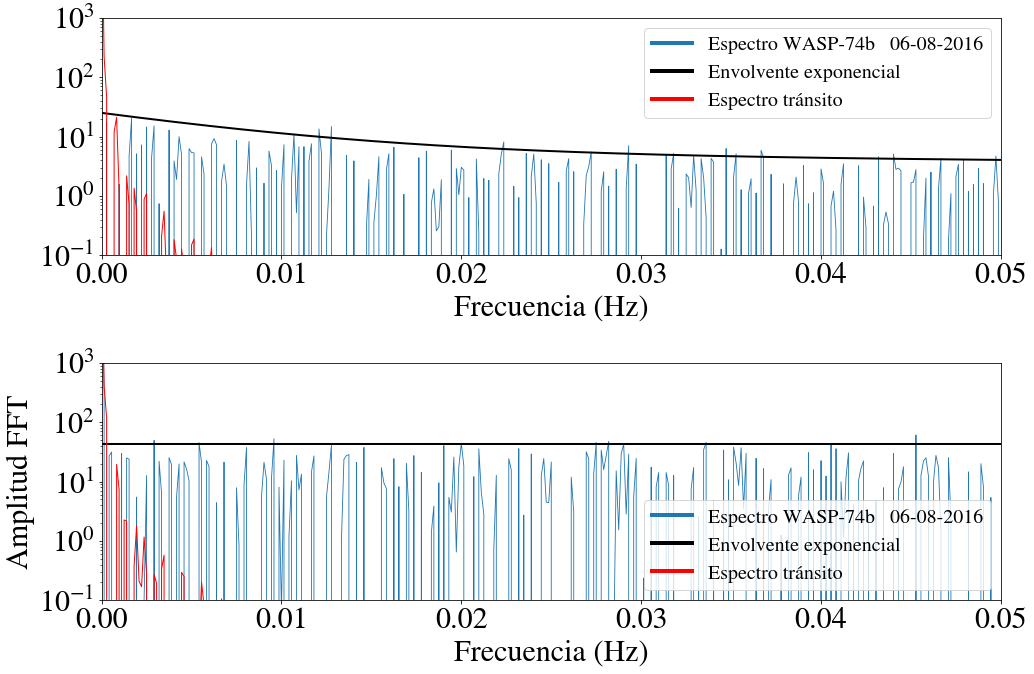

In [29]:
fig=plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.semilogy(freq,fft_lc.real,linewidth=0.85,label='Espectro WASP-74b   06-08-2016'); # GRAFICANDO LA FFT DE LA CURVA DE LUZ
plt.semilogy(freq[:1000],expo[:1000],linewidth=2,color='k',label='Envolvente exponencial')
plt.semilogy(freq,fft_transito_wasp.real,linewidth=1,color='r',label='Espectro tránsito')
plt.xlabel('Frecuencia (Hz)',size=30)
plt.xlim(0,0.05)
plt.ylim(0.1,1000)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=20)


for line in leg.get_lines():
    line.set_linewidth(4.0) 

expo2=dexp(freq,43,0, 15.55364026e-02, 0,8.90201637e-03)
    
plt.subplot(2, 1, 2)
plt.semilogy(freq,fft_lc_hat37.real,linewidth=0.85,label='Espectro WASP-74b   06-08-2016'); # GRAFICANDO LA FFT DE LA CURVA DE LUZ
plt.semilogy(freq,expo2,linewidth=2,color='k',label='Envolvente exponencial')
plt.semilogy(freq,fft_transito.real,linewidth=1,color='r',label='Espectro tránsito')
plt.xlabel('Frecuencia (Hz)',size=30)
plt.ylabel('Amplitud FFT',size=30)
plt.xlim(0,0.05)
plt.ylim(0.1,1000)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

fig.tight_layout(pad=3.0)
plt.savefig('../reports/figures/comparacion_espectros_resultados.png',dpi=300)

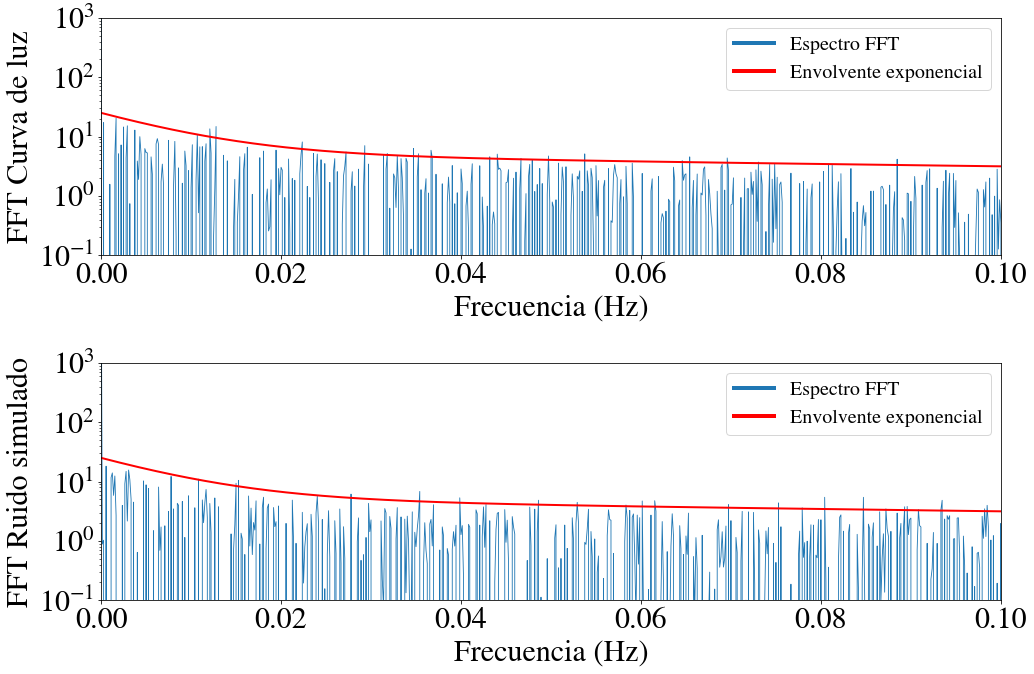

In [28]:
fig=plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.semilogy(freq,fft_lc.real,linewidth=0.85,label='Espectro FFT'); # GRAFICANDO LA FFT DE LA CURVA DE LUZ
plt.semilogy(freq[:10000],expo[:10000],linewidth=2,color='r',label='Envolvente exponencial')
plt.xlabel('Frecuencia (Hz)',size=30)
plt.ylabel('FFT Curva de luz',size=30)
plt.xlim(0,0.1)
plt.ylim(0.1,1000)
plt.xticks(size=30)
plt.yticks(size=30)
leg = plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.subplot(2, 1, 2)
plt.semilogy(freq,fft_ruido_real.real,linewidth=0.85,label='Espectro FFT'); # GRAFICANDO LA FFT DE LA CURVA DE RUIDO SIMULADO
plt.semilogy(freq[:10000],expo[:10000],linewidth=2,color='r',label='Envolvente exponencial')
plt.xlabel('Frecuencia (Hz)',size=30)
plt.ylabel('FFT Ruido simulado',size=30)
plt.xlim(0,0.1)
plt.ylim(0.1,1000)
plt.xticks(size=30)
plt.yticks(size=30)
leg = plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0) 
    
fig.tight_layout(pad=3.0)
plt.savefig('../reports/figures/comparacion_espectros.png',dpi=300)

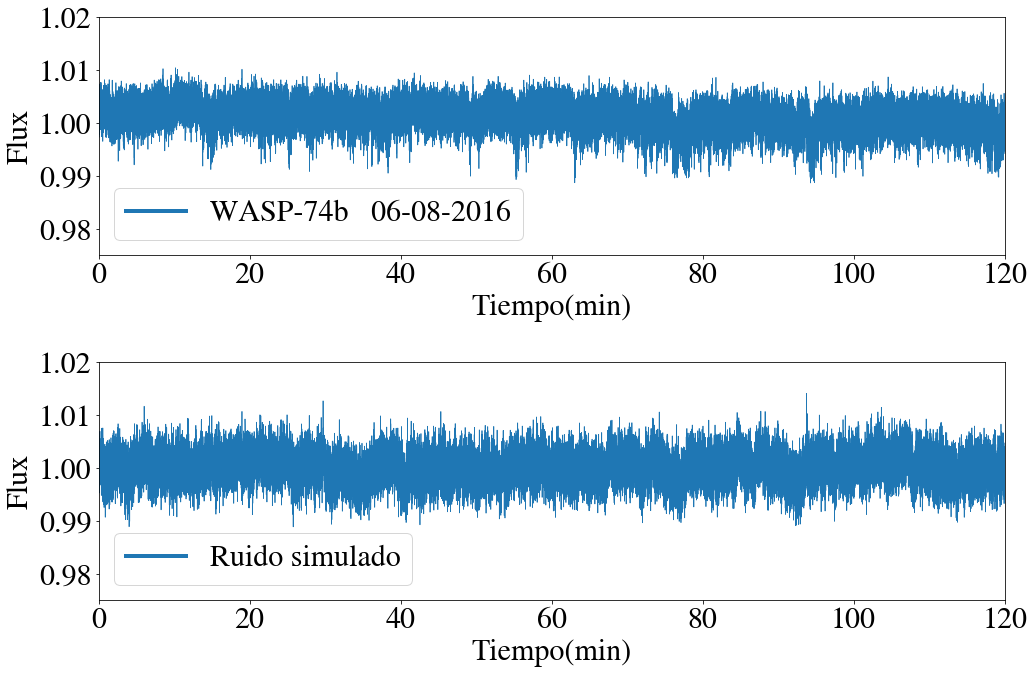

In [86]:
fig=plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(t_lc,lc,linewidth=0.75,label='WASP-74b   06-08-2016')
#plt.title('Name:Wasp74b Date:06ago16 SNR={0:.4f} Cam:Ixon Tel:84cm'.format(snr_lc))
plt.xlabel('Tiempo(min)',size=30)
plt.ylabel('Flux',size=30)
plt.xlim(0,120)
plt.ylim(0.975,1.02)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

plt.subplot(2, 1, 2)
plt.plot(t_lc,ruido_r,linewidth=0.75,label='Ruido simulado')
#plt.title('Name:Wasp74b Date:06ago16 SNR={0:.4f} Cam:Ixon Tel:84cm'.format(snr_lc))
plt.xlabel('Tiempo(min)',size=30)
plt.ylabel('Flux',size=30)
plt.xlim(0,120)
plt.ylim(0.975,1.02)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

fig.tight_layout(pad=3.0)
plt.savefig('../reports/figures/comparacion_series_tiempo.png',dpi=300)

In [38]:
ruido=np.random.randn(10000)
histo,x=np.histogram(ruido,20)
x_hist=(x[:-1]+x[1:])/2

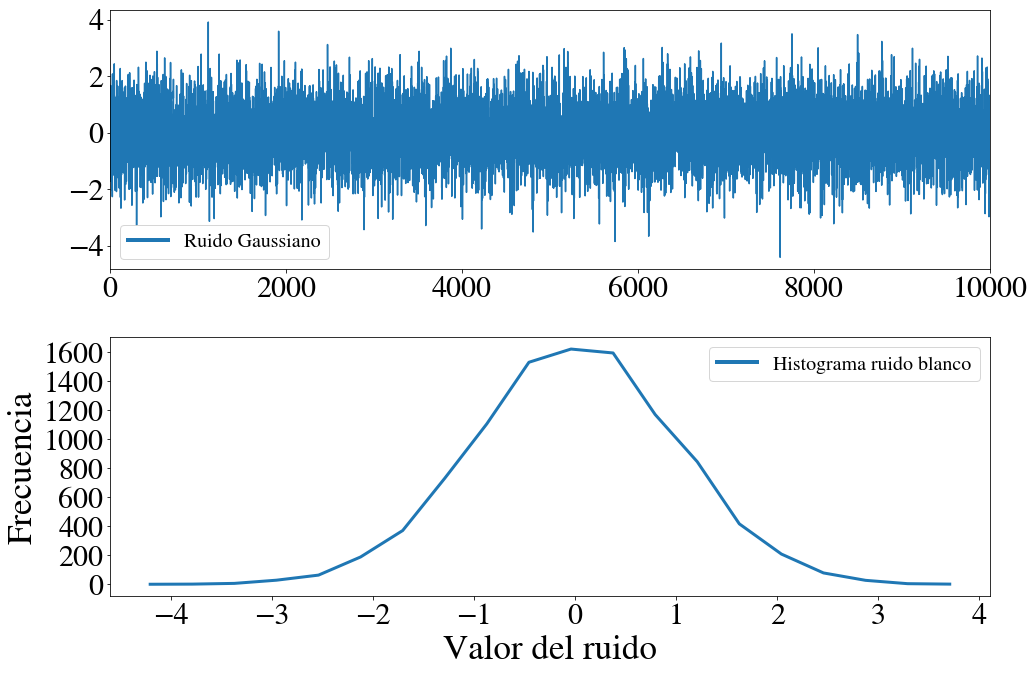

In [39]:
fig=plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(ruido,label='Ruido Gaussiano')
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=20)
plt.xlim(0,10000)
for line in leg.get_lines():
    line.set_linewidth(4.0) 

plt.subplot(2, 1, 2)
plt.plot(x_hist,histo,label= 'Histograma ruido blanco',linewidth=3)
plt.ylabel("Frecuencia",size=35)
plt.xlabel("Valor del ruido",size=35)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=20)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

fig.tight_layout(pad=3.0)
#plt.savefig('../reports/figures/ejemplo_ruido_gauss.png',dpi=300)

In [75]:
ruido_r=ruido_real(snr_lc,1,4.09589900e+00, 15.55364026e-02, 20,8.90201637e-03,288000)

In [77]:
ruido_r?

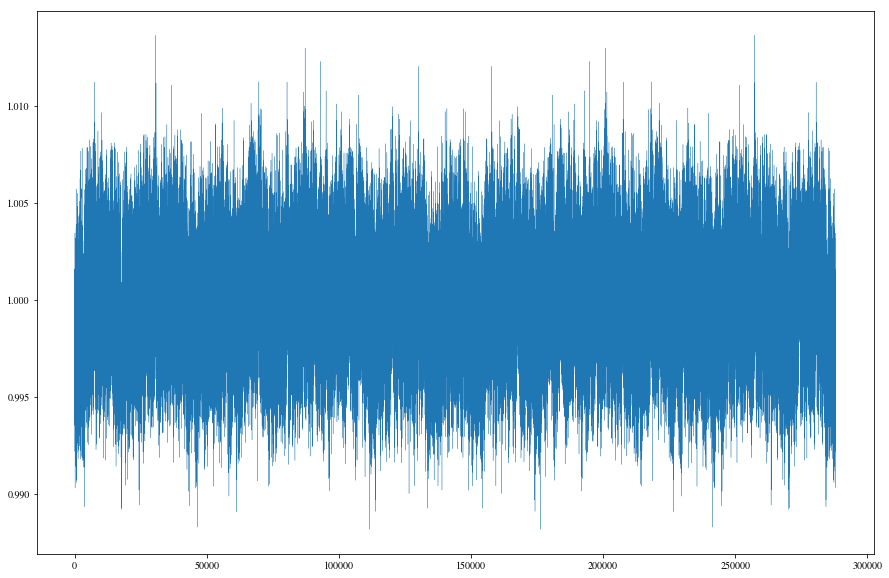

In [81]:
fig=plt.figure(figsize=(15,10))
plt.plot(ruido_r,linewidth=0.3)

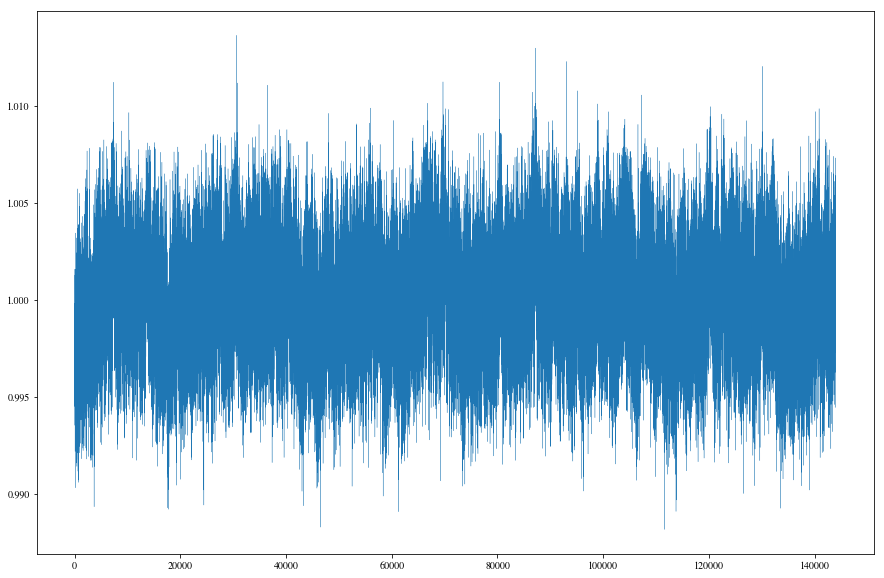

In [82]:
fig=plt.figure(figsize=(15,10))
plt.plot(ruido_r[:144000],linewidth=0.3)

In [23]:
lcx4=np.loadtxt('../data/transitohat37.out');   ###TRANSITO SIMULADO PARA HATP37B
lcx3=np.loadtxt('../data/hatp37_7ago.out');#### HATP37B CON TRANSITO DEL 7 DE AGOSTO 2016 IXON

In [24]:
size=144000
size1=lcx3.shape[0]
size3=lcx4.shape[0]


lcx_1=lcx3[10000:154000]
lcx_2=lcx3[size1-144000:size1]
transito_1=lcx4[10000:154000]
transito_2=lcx4[size3-144000:size3]

########################acomodando transito
shift=15000
transito1=np.zeros(size)
transito1[:]=transito1[:]+1

for i in range(size-shift):
	transito1[i+shift]=transito_1[i]

transito_1=transito1

shift=22000
transito2=np.zeros(size)
transito2[:]=transito2[:]+1
for i in range(size-shift):
	transito2[i]=transito_2[i+shift]

transito_2=transito2



In [25]:
fft_lc_hat37=np.fft.fft(lcx_2)

In [26]:
transito_1=lcx4[10000:154000]
transito_2=lcx4[len(lcx4)-144000:len(lcx4)]
fft_transito=np.fft.fft(transito_2)
fft_transito_wasp=np.fft.fft(tran_wasp[:144000])
############TRANSFORMADA DE FOURIER DE LA CURVA DE LUZ
freq = np.fft.fftfreq(len(transito_2),d=0.05)

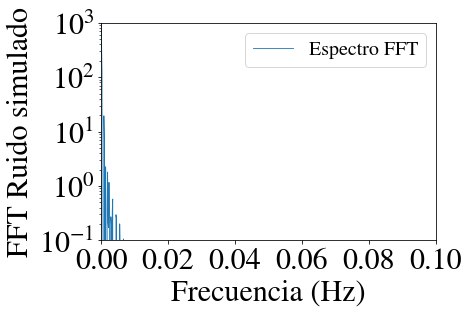

In [14]:
plt.semilogy(freq,fft_transito.real,linewidth=0.85,label='Espectro FFT'); # GRAFICANDO LA FFT DE LA CURVA DE RUIDO SIMULADO
plt.xlabel('Frecuencia (Hz)',size=30)
plt.ylabel('FFT Ruido simulado',size=30)
plt.xlim(0,0.1)
plt.ylim(0.1,1000)
plt.xticks(size=30)
plt.yticks(size=30)
leg = plt.legend(fontsize=20)

In [21]:
tran_wasp=np.loadtxt('../data/transitowasp.out');#### HATP37B CON TRANSITO DEL 7 DE AGOSTO 2016 IXON

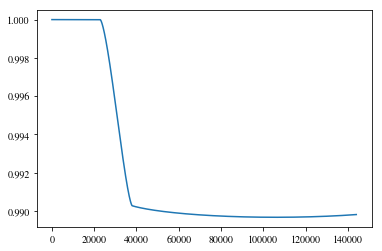

In [26]:
plt.plot(tran_wasp[:144000])